### Notatki
- trzeba zamienić x i y (kolumny) miejscami,
- wynikowy obraz jest obrócony (przez odejmowanie?) i przerzucony w poziomie,

In [97]:
import cv2
import numpy as np
from pyproj import Proj, transform
import json
import os
import matplotlib.pyplot as plt
from PIL import Image

In [76]:
def convert_coords(x, y, proj_src="EPSG:2180", proj_dst="EPSG:4326"):
    proj_src = Proj(proj_src)
    proj_dst = Proj(proj_dst)

    lon, lat = transform(proj_src, proj_dst, x, y)

    return lon, lat

In [87]:
path = r"C:\Users\gtraw\OneDrive\Pulpit\UM sem. 2\ProjektBadawczy\apps\image_processing\images"
data_weti1 = {}
data_weti2 = {}
for i, filename in enumerate(os.listdir(path)):
        f = os.path.join(path, filename)
        if os.path.isfile(f) and filename.endswith(".json"):
                with open(f) as json_file:
                        json_data = json.load(json_file)
                for obj in json_data['objects']:
                        id_data, point_data = obj['tags'].split(';')
                        _, name = id_data.split()
                        x, y = point_data.replace(point_data.split()[0], '').split(',')
                        if 'weti1' in filename:
                                data_weti1[name] = {
                                        'geo_coords': [float(y.strip()), float(x.strip())], #[float(x.strip()), float(y.strip())],
                                        'img_coords': obj['points']
                                }
                        elif 'weti2' in filename:
                                data_weti2[name] = {
                                        'geo_coords': [float(y.strip()), float(x.strip())], #[float(x.strip()), float(y.strip())],
                                        'img_coords': obj['points']
                                }

### Load and preprocess images

In [127]:
def crop_img_with_mask(image, mask):
    alpha_channel = mask[:, :, 3]

    rows, cols = alpha_channel.shape
    first_row, last_row = 0, rows - 1
    first_col, last_col = 0, cols - 1

    for i in range(rows):
        if np.any(alpha_channel[i, :] == 0):
            first_row = i
            break

    for i in range(rows - 1, -1, -1):
        if np.any(alpha_channel[i, :] == 0):
            last_row = i
            break

    for j in range(cols):
        if np.any(alpha_channel[:, j] == 0):
            first_col = j
            break

    for j in range(cols - 1, -1, -1):
        if np.any(alpha_channel[:, j] == 0):
            last_col = j
            break

    cropped_image = image[first_row:last_row+1, first_col:last_col+1]
    return cropped_image, (first_col, first_row, last_col, last_row)

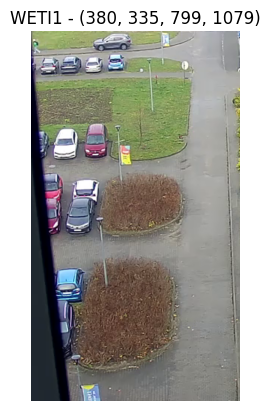

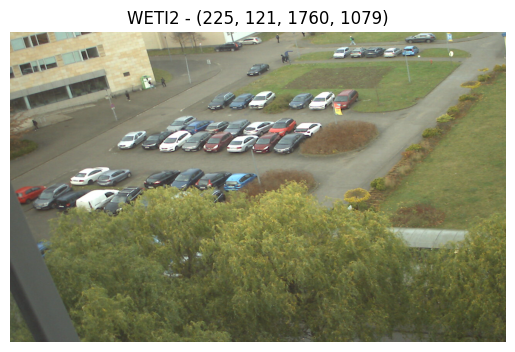

In [131]:
image_weti1 = cv2.cvtColor(cv2.imread(r"C:\Users\gtraw\OneDrive\Pulpit\UM sem. 2\ProjektBadawczy\apps\image_processing\images\surf1.jpg"), cv2.COLOR_RGB2BGR)
image_weti2 = cv2.cvtColor(cv2.imread(r"C:\Users\gtraw\OneDrive\Pulpit\UM sem. 2\ProjektBadawczy\apps\image_processing\images\surf2.jpg"), cv2.COLOR_RGB2BGR)

mask_weti1 = np.array(Image.open(r"C:\Users\gtraw\OneDrive\Pulpit\UM sem. 2\ProjektBadawczy\apps\image_processing\images\weti1_mask.jpg").convert("RGBA"))
mask_weti2 = np.array(Image.open(r"C:\Users\gtraw\OneDrive\Pulpit\UM sem. 2\ProjektBadawczy\apps\image_processing\images\weti2_mask.jpg").convert("RGBA"))

image_c_weti1, bbox_weti1 = crop_img_with_mask(image_weti1, mask_weti1)
image_c_weti2, bbox_weti2 = crop_img_with_mask(image_weti2, mask_weti2)

plt.imshow(image_c_weti1)
plt.title(f"WETI1 - {bbox_weti1}")
plt.axis("off")
plt.show()
plt.imshow(image_c_weti2)
plt.title(f"WETI2 - {bbox_weti2}")
plt.axis("off")
plt.show()

In [137]:
# keys_weti1 = data_weti1.keys()
# geo_points_weti1 = np.array([data_weti1[k]['geo_coords'] for k in keys_weti1])
# img_points_weti1 = np.array([data_weti1[k]['img_coords'] for k in keys_weti1])
# # print(img_points_weti1, '\n--------')
# keys_weti2 = data_weti2.keys()
# geo_points_weti2 = np.array([data_weti2[k]['geo_coords'] for k in keys_weti2])
# img_points_weti2 = np.array([data_weti2[k]['img_coords'] for k in keys_weti2])
# # print(img_points_weti2, '\n------------------------------------')

keys_weti1 = data_weti1.keys()
geo_points_weti1 = np.array([data_weti1[k]['geo_coords'] for k in keys_weti1])
img_points_weti1 = np.array([data_weti1[k]['img_coords'] - np.array(bbox_weti1[:2]) for k in keys_weti1])
# print(img_points_weti1, '\n--------')
keys_weti2 = data_weti2.keys()
geo_points_weti2 = np.array([data_weti2[k]['geo_coords'] for k in keys_weti2])
img_points_weti2 = np.array([data_weti2[k]['img_coords'] - np.array(bbox_weti2[:2]) for k in keys_weti2])
# print(img_points_weti2)

In [136]:
# print(img_points_weti1,'\n----------------------------------')

# print(geo_points_weti1,'\n----------------------------------')

# Offset EPSG:2180 points to start at (0, 0) by subtracting minimums
geo_points_weti1[:, 0] -= geo_points_weti1[:, 0].min()
geo_points_weti1[:, 1] -= geo_points_weti1[:, 1].min()

# print(geo_points_weti1,'\n----------------------------------')

# tmp = geo_points_weti1[:, 0]
# geo_points_weti1[:, 0] = geo_points_weti1[:, 1]
# geo_points_weti1[:, 1] = tmp

# Scale geo points to match image dimensions for homography calculation
scale_x = image_weti1.shape[1] / geo_points_weti1[:, 0].max()
scale_y = image_weti1.shape[0] / geo_points_weti1[:, 1].max()

geo_points_weti1[:, 0] *= scale_x
geo_points_weti1[:, 1] *= scale_y

# print(geo_points_weti1)

# # Compute the homography matrix
# homography_matrix_weti1, status_weti1 = cv2.findHomography(img_points_weti1, geo_points_weti1)

# # Warp the image using the computed homography
# img1_warp = cv2.warpPerspective(image_weti1, homography_matrix_weti1, (image_weti1.shape[1], image_weti1.shape[0]))

# # Display the transformed image
# plt.imshow(img1_warp)
# plt.show()


# Homography

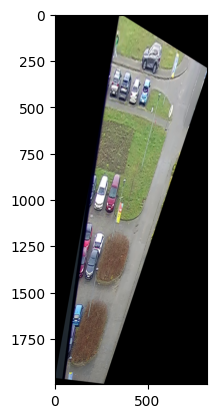

In [144]:
# weti1

keys_weti1 = data_weti1.keys()
geo_points_weti1 = np.array([data_weti1[k]['geo_coords'] for k in keys_weti1])
img_points_weti1 = np.array([data_weti1[k]['img_coords'] - np.array(bbox_weti1[:2]) for k in keys_weti1])
image_weti1 = image_c_weti1

# weti2
# keys_weti2 = data_weti2.keys()
# geo_points_weti1 = np.array([data_weti2[k]['geo_coords'] for k in keys_weti2])
# img_points_weti1 = np.array([data_weti2[k]['img_coords'] - np.array(bbox_weti2[:2]) for k in keys_weti2])
# image_weti1 = image_c_weti2

# ------------------------------------------------------------------------------------------

geo_points_weti1[:, 0] -= geo_points_weti1[:, 0].min()
geo_points_weti1[:, 1] -= geo_points_weti1[:, 1].min()

scale_x = image_weti1.shape[1] / geo_points_weti1[:, 0].max()
scale_y = image_weti1.shape[0] / geo_points_weti1[:, 1].max()

geo_points_weti1[:, 0] *= scale_x
geo_points_weti1[:, 1] *= scale_y

homography_matrix_weti1, status_weti1 = cv2.findHomography(img_points_weti1, geo_points_weti1)

height, width = image_weti1.shape[:2]

image_corners = np.array([
    [0, 0],              
    [width, 0],          
    [width, height],     
    [0, height]          
], dtype="float32")

transformed_corners = cv2.perspectiveTransform(image_corners.reshape(-1, 1, 2), homography_matrix_weti1).reshape(-1, 2)

x_min, y_min = transformed_corners.min(axis=0)
x_max, y_max = transformed_corners.max(axis=0)

output_width = int(x_max - x_min)
output_height = int(y_max - y_min)

translation_matrix = np.array([
    [1, 0, -x_min],
    [0, 1, -y_min],
    [0, 0, 1]
])

adjusted_homography = np.dot(translation_matrix, homography_matrix_weti1)

img1_warp_full = cv2.warpPerspective(image_weti1, adjusted_homography, (output_width, output_height))

plt.imshow(cv2.flip(cv2.rotate(img1_warp_full, cv2.ROTATE_180), 1))
plt.show()
